# Homework 8.9 - Coding

This is the coding portion of the homework assignment for Section 8.9

In [400]:
from typing import Callable
import numpy as np
from matplotlib import pyplot as plt

The following is Algorithm 8.3 from the book for taking the wavelet transform of an array of samples, edited to make it more readable/functional.

In [401]:
def FWT(a: np.ndarray, j: int=0) -> np.ndarray:
    """Haar Wavelet Transform of the sample `a` down to level j

    Parameters:
        a (np.ndarray) - An array (with length an integer power of 2) 
            containing the samples we'd like to take the FWT of 
        j (int) - The level to perform the FWT down to 
    
    Returns:
        np.ndarray - The FWT of the sample (coefficients of corresponding basis functions)
            in the format [a_{00}, b_{00}, b_{10}, b_{11}, ...]
    """
    m = int(np.log2(len(a)))
    L = []

    # Consturct a and b vectors
    while m > j:
        L.extend(np.flip(0.5 * (a[::2] - a[1::2])))
        a = 0.5 * (a[::2] + a[1::2])
        m -= 1
    
    
    # Return finished transform
    return np.concatenate((a, np.flip(L)))

Before beginning the following problems, write functions `son()` and `daughter()` that accept:

1. An array `x` of inputs in $[0,1)$
2. Integers `n, k` representing the index of the son function $\rho_{n,k}$ or daughter function $\psi_{n,k}$ to implement

These should return a numpy array of the same size of `x`, containing the values of the corresponding son or daughter function evaluated at each point of `x`. 

In [402]:
def son(x: np.ndarray, n: int, k: int) -> np.ndarray:


    return ((x >= (k/(2**n))) & (x < ((k + 1)/(2**n)))).astype(float)

In [403]:
def daughter(x: np.ndarray, n: int, k: int) -> np.ndarray:

    return son(x, n+1, 2*k) - son(x, n+1, 2*k + 1)
    

Finally, copy your function `sample_f()` from Problem 8.42(i) into the following cell:

In [404]:
def sample_f(
    f: Callable[[float | np.ndarray], float | np.ndarray],
    n: int
) -> np.ndarray:
    """Samples the function f at 2^n points from 0 to (2^n - 1)/(2^n)"""
    k = np.arange(0, 2**n)
    x = k / (2**n)
    return f(x)


---

## Problem 8.45

### Part (i)

Write a function `wavelet_approx()` that takes as input:

1. The wavelet transform `transform` = $[a_{00}, b_{00}, b_{10}, b_{11}, \ldots]$ as a numpy array
2. An integer `j`

Your function should return:

1. The approximation $T_j[f] \in V_j$ as a callable function that accepts/returns numpy arrays 
2. The detail $g_j \in V_j^\perp$ as a callable function that accepts/returns numpy arrays 

In [ ]:
def wavelet_approx(
    transform: np.ndarray,
    j: int
) -> tuple[Callable[[np.ndarray], np.ndarray], Callable[[np.ndarray], np.ndarray]]:
    """Return the wavelet approximation/detail of a function, given its wavelet transform.
    
    Parameters:
        a (np.ndarray): The wavelet transform of a function, 
            given in the format [a_{00}, b_{00}, b_{10}, b_{11}, ...]
        j (int): The level of the wavelet transform to work up to

    Returns: 
        Callable - The approximation T_j[f] as a callable function 
        Callable - The detail g_j as a callable function
    """
    
    
    # Parse coefficients
    a0 = transform[0]
    bs = transform[1:]


    # Build approximation T_j
    def T_j(x):
        total = a0 * son(x, 0, 0)       # base scaling function
        index = 0

        for level in range(j):
            for k in range(2**level):
                total += bs[index] * daughter(x, level, k)
                index += 1

        return total

    # return T_j, g_j
    def g_j(x):
        total = 0
        index = 1
        for level in range(j):
            index += 2**level
        level = j
        while index < len(transform):
            for k in range(2**level):
                total += transform[index] * daughter(x, level, k)
                index += 1
            level += 1
        return total
    return T_j, g_j


### Part (ii)

Apply your code to the function (8.57), given by 
$$f(t) = 100 t^2 (1-t) \left| \sin \left(\frac{10t}{3}\right) \right|$$

Reproduce the plots for $j=2, j=4$, and $j=6$ given in Figure 8.18 in the book.

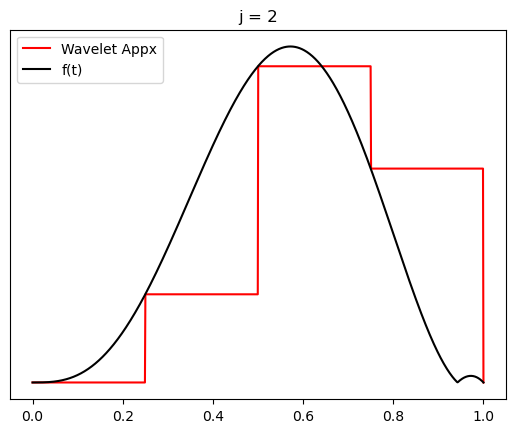

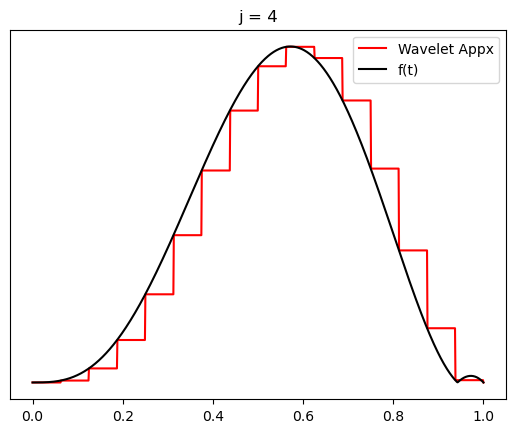

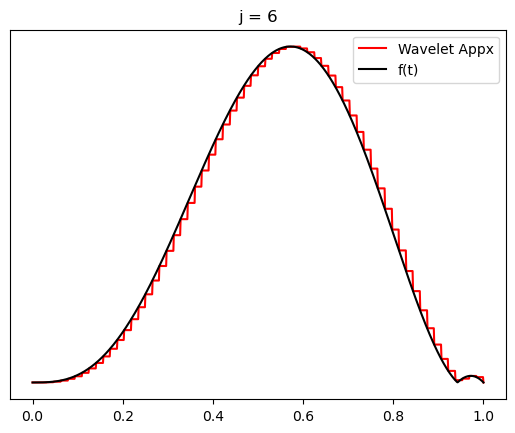

In [406]:
x = np.linspace(0, 1, 1000)
f = lambda t: 100*(t**2) * (1 - t) * np.abs(np.sin(10*t/3))

for j in [2, 4, 6]:
    samples = sample_f(f, j)
    transform = FWT(samples)
    fj, g = wavelet_approx(transform, j)

    plt.figure()
    plt.plot(x, fj(x), label="Wavelet Appx", color="red")
    plt.plot(x, f(x), label="f(t)", color="black")
    plt.yticks([])  
    plt.legend()
    plt.title(f"j = {j}")
    plt.show()


---

## Problem 8.46

### Part (i)

Construct a method `sample_f_wavelet_approx()` which takes as input:

1. A callable function $f$ defined on $[0,1)$,
2. A positive integer $\ell$, and
3. A positive integer $j < \ell$

Your function should do the following:
1. Sample $f$ at $2^{\ell}$ equally-spaced points (excluding the right endpoint) to get the samples/approximation $f_{\ell}$
2. Obtain the FWT of the samples $f_{\ell}$
3. Using the FWT coefficients, obtain the two callable functions $T_j[f] \in V_j$ and $g_j \in V_j^\perp$ such that $f_{\ell} = T_j[f] + g_j$

Your function should return:
1. The approximation $T_j[f] \in V_j$ as a callable function that accepts/returns numpy arrays 
2. The detail $g_j \in V_j^\perp$ as a callable function that accepts/returns numpy arrays

In [407]:
def sample_f_wavelet_approx(
    f: Callable[[np.ndarray], np.ndarray],
    l: int,
    j: int
) -> tuple[Callable[[np.ndarray], np.ndarray], Callable[[np.ndarray], np.ndarray]]:
    """Return the j-th level wavelet approximation/detail of f_l,
    which is the lth-level wavelet approximation of f.
    
    Parameters:
        f (Callable): A function defined on [0,1) to sample from
        l (int): The level of the "higher" level wavelet approximation of f
        j (int): The level of the "lower" level wavelet approximation of f_l

    Returns: 
        Callable - The approximation T_j[f] as a callable function 
        Callable - The detail g_j as a callable function
    """
    samples = sample_f(f, l)
    coeffs = FWT(samples)
    T_f, g = wavelet_approx(coeffs, j)

    return T_f, g

    

### Part (ii)

Apply your methods to the function (8.99):

$$f(t) = \frac{\sin(2\pi t - 5)}{\sqrt{\left| t - \frac{\pi}{20} \right|}}$$

for $\ell = 10$.

For each value of $j \in \{0, 1, \ldots, \ell - 1\}$, plot each of the functions $T_j[f]$ and $g_j$ (make sure to title/label your plots)!

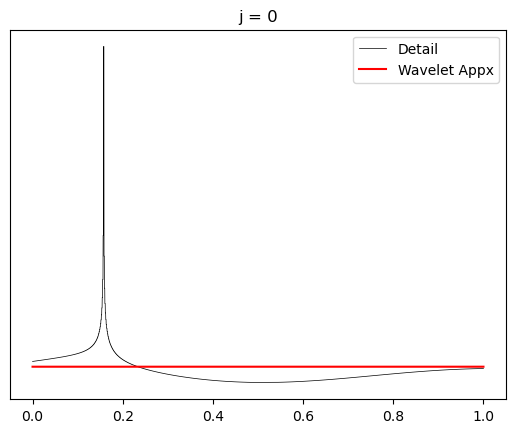

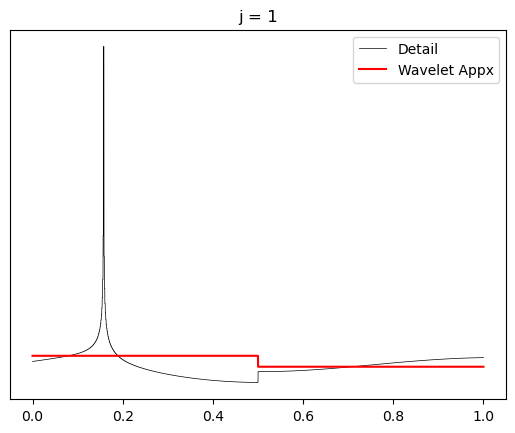

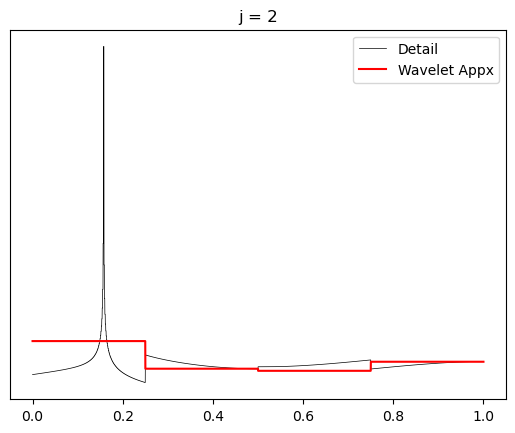

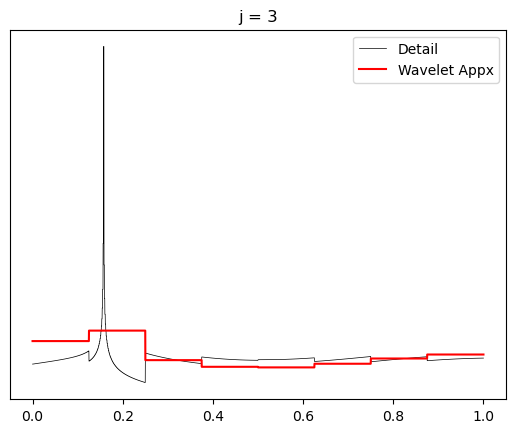

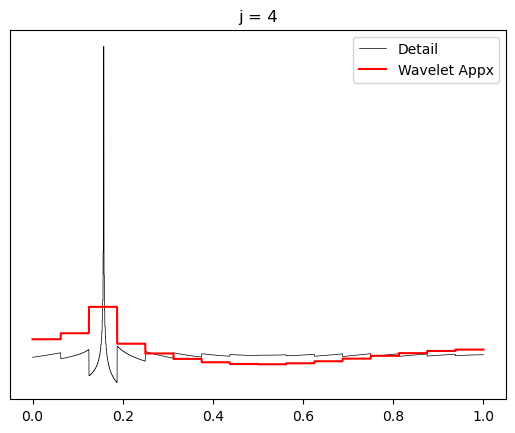

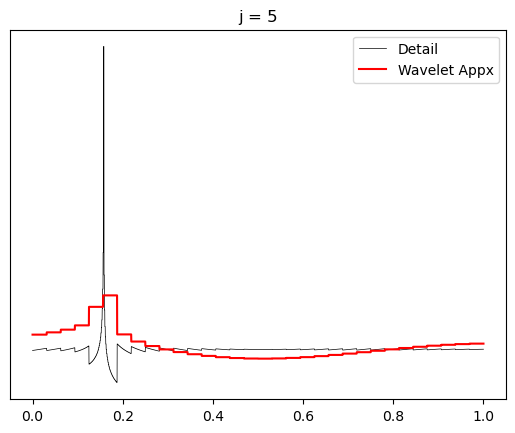

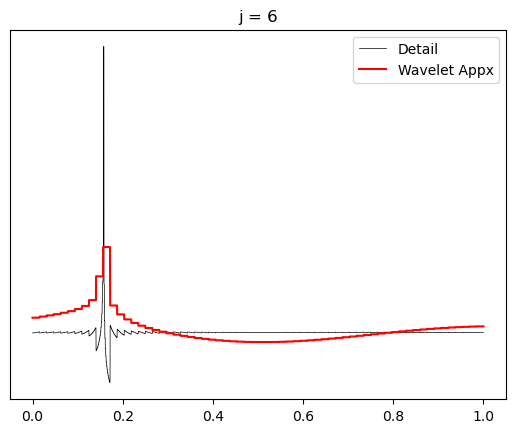

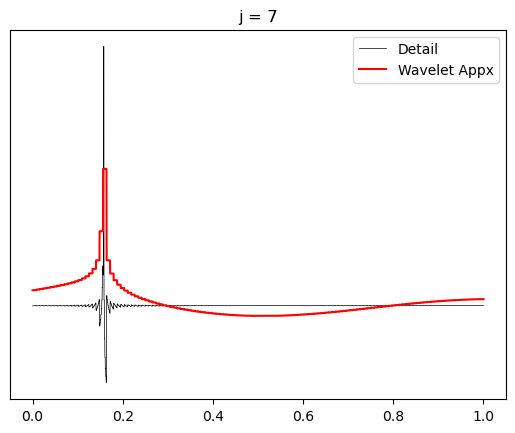

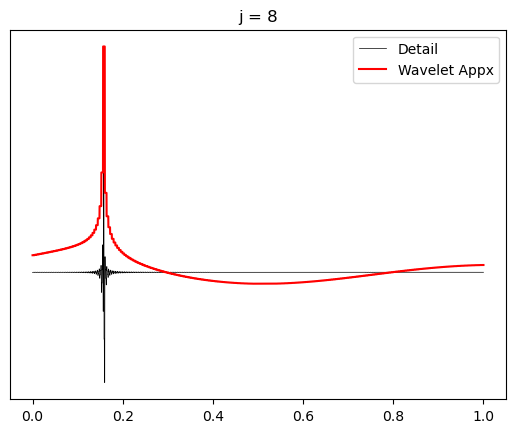

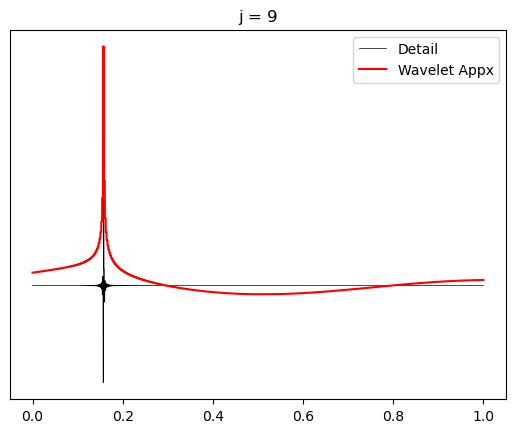

In [408]:
f = lambda t: (np.sin(2*np.pi*t - 5)) / np.sqrt(np.abs(t - (np.pi / 20)))
l = 10
x = np.linspace(0, 1, 10000, endpoint=False)
for j in range(l):
    T_f, g = sample_f_wavelet_approx(f, l, j)
    plt.figure()
    plt.plot(x, g(x), label="Detail", color="black", linewidth=0.5)
    plt.plot(x, T_f(x), label="Wavelet Appx", color="red")
    plt.yticks([])  
    plt.legend()
    plt.title(f"j = {j}")
    plt.show()


### Part (iii)

In the following markdown cell, compare the plots of each $T_j[f]$ to the corresponding plots in Exercise 8.42. In both cases, they are functions in $V_j$, but they are not identical. Explain the difference. Explain why it occurs. 

**Response:** _In 8.42 the problem used sons exclusively to compute the approximation.  It also always had l=j, whereas here j can be below l._

---

## Problem 8.47

Generalize your code from the previous problems to work for a function $f$ defined on an arbitrary interval $[a,b]$ in the following steps:

### Part (i)

Write functions to generalize the Haar son, Haar daughter, and the sampling functions to general intervals $[a,b]$.

(You may call your previous functions `son()`, `daughter()`, and `sample_f_general()` if you'd like).

In [409]:
def son_general(x: np.ndarray, n: int, k: int, a: float, b: float) -> np.ndarray:
    """A callble version of the Haar son function on the interval [a, b]"""
    
    return ((x >= (k*(b-a)/(2**n))) & (x < ((k + 1)*(b-a)/(2**n)))).astype(float)
    

In [410]:
def daughter_general(x: np.ndarray, n: int, k: int, a: float, b: float) -> np.ndarray:
    """A callable version of the Haar daughter function on the interval [a, b]"""

    return son_general(x, n+1, 2*k, a, b) - son_general(x, n+1, 2*k + 1, a, b)

In [411]:
def sample_f_general(
    f: Callable[[float | np.ndarray], float | np.ndarray],
    n: int, 
    a: float, 
    b: float
) -> np.ndarray:
    """Samples the function f at 2^n points equally spaced points on [a,b]
    (excluding the right endpoint)"""


    """Samples the function f at 2^n points from 0 to (2^n - 1)/(2^n)"""
    
    k = np.arange(0, 2**n)
    x = a + ((b-a)*k / (2**n))
    return f(x)

    

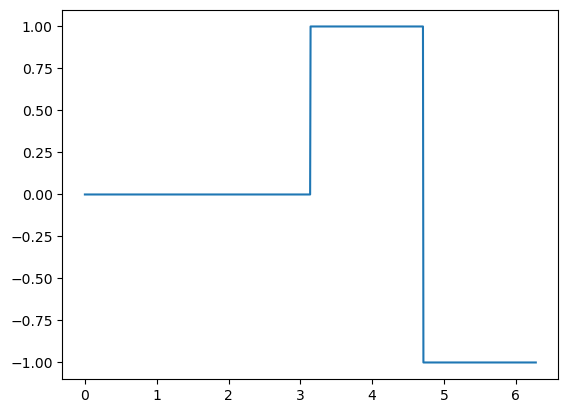

In [412]:
a = 0
b = 2*np.pi
n = 1
k = 1
x = np.linspace(a, b, 1000, endpoint=False)
d = daughter_general(x, n, k, a, b)
plt.plot(x, d)

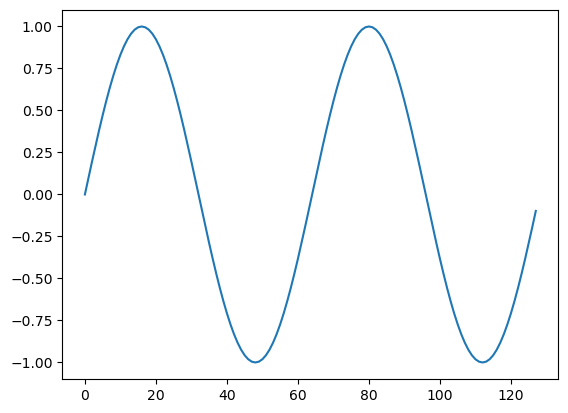

In [413]:
f = lambda x: np.sin(x)
samples = sample_f_general(f, 7, 0, 4*np.pi)
plt.plot(samples)

Now, write a function `wavelet_approx_general()` that takes as input:

1. The wavelet transform `transform` = $[a_{00}, b_{00}, b_{10}, b_{11}, \ldots]$ as a numpy array
2. An integer `j`
3. The left endpoint `a` of the interval $[a,b]$ that $f$ is defined on
4. The right endpoint `b` of the interval $[a,b]$ that $f$ is defined on

Your function should return:

1. The approximation $T_j[f] \in V_j$ as a callable function that accepts/returns numpy arrays 
2. The detail $g_j \in V_j^\perp$ as a callable function that accepts/returns numpy arrays 

In [414]:
def wavelet_approx_general(
    transform: np.ndarray,
    j: int, 
    a: float, 
    b: float
) -> tuple[Callable[[np.ndarray], np.ndarray], Callable[[np.ndarray], np.ndarray]]:
    """Return the wavelet approximation/detail of a function, given its wavelet transform.
    
    Parameters:
        transform (np.ndarray): The wavelet transform of a function, 
            given in the format [a_{00}, b_{00}, b_{10}, b_{11}, ...]
        j (int): The level of the wavelet transform to work up to
        a (float): The left endpoint of the interval [a,b] (the domain of the transformed function)
        b (float): The right endpoint of the interval [a,b] (the domain of the transformed function)

    Returns: 
        Callable - The approximation T_j[f] as a callable function 
        Callable - The detail g_j as a callable function
    """
    
    # Parse coefficients
    a0 = transform[0]
    bs = transform[1:]


    # Build approximation T_j
    def T_j(x):
        total = a0 * son_general(x, 0, 0, a, b)       # base scaling function
        index = 0

        for level in range(j):
            for k in range(2**level):
                total += bs[index] * daughter_general(x, level, k, a, b)
                index += 1

        return total

    # Build detail g_j
    def g_j(x):
        total = 0
        index = 1
        for level in range(j):
            index += 2**level
        level = j
        while index < len(transform):
            for k in range(2**level):
                total += transform[index] * daughter_general(x, level, k, a, b)
                index += 1
            level += 1
        return total
    return T_j, g_j

    return T_j, g_j

Finally, implement the method `sample_f_wavelet_approx_general()`, which takes as input:

1. A callable function $f$ defined on $[a,b]$,
2. The floating-point number $a$
3. The floating-point number $b$
4. A positive integer $\ell$, and
5. A positive integer $j < \ell$

Your function should do the following:
1. Sample $f$ on $[a,b]$
2. Construct the Haar wavelet transform of the sampled $f$ on that interval
3. Find the two functions $T_j[f] \in V_j$ and $g_j \in V_j^\perp$ such that $f_{\ell} = T_j[f] + g_j$

Your function should return:
1. The approximation $T_j[f] \in V_j$ as a callable function that accepts/returns numpy arrays 
2. The detail $g_j \in V_j^\perp$ as a callable function that accepts/returns numpy arrays 

In [415]:
def sample_f_wavelet_approx_general(
    f: Callable[[np.ndarray], np.ndarray],
    a: float, 
    b: float,
    l: int,
    j: int
) -> tuple[Callable[[np.ndarray], np.ndarray], Callable[[np.ndarray], np.ndarray]]:
    """Return the j-th level wavelet approximation/detail of f_l,
    which is the lth-level wavelet approximation of f (which is 
    defined on [a,b], a compact interval)/
    
    Parameters:
        f (Callable): A function defined on [a,b] to sample from
        a (float): The left endpoint of the compact domain [a, b] of f
        b (float): The right endpoint of the compact domain [a, b] of f
        l (int): The level of the "higher" level wavelet approximation of f
        j (int): The level of the "lower" level wavelet approximation of f_l

    Returns: 
        Callable - The approximation T_j[f] as a callable function 
        Callable - The detail g_j as a callable function
    """
    samples = sample_f_general(f, l, a, b)
    coeffs = FWT(samples)
    T_f, g = wavelet_approx_general(coeffs, j, a, b)

    return T_f, g

### Part (ii)

Apply this method to the function (8.99)

$$f(t) = \frac{\sin(2\pi t - 5)}{\sqrt{\left| t - \frac{\pi}{20} \right|}}$$

defined on the interval $[-1, 1]$ for $\ell = 10$.

For each value of $j \in \{0, 1, \ldots, \ell - 1\}$, plot each of the functions $T_j[f]$ and $g_j$ (make sure to title/label your plots)!

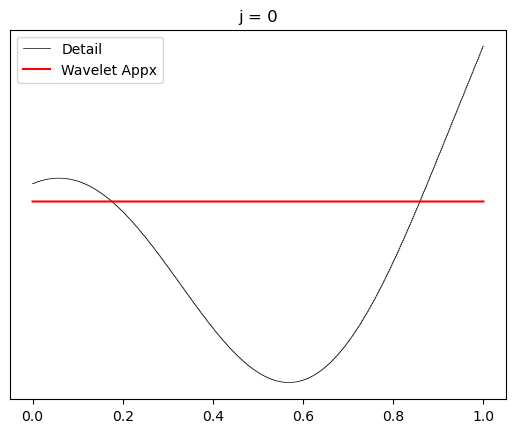

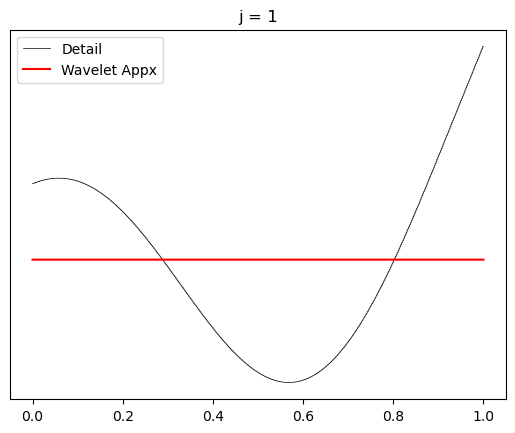

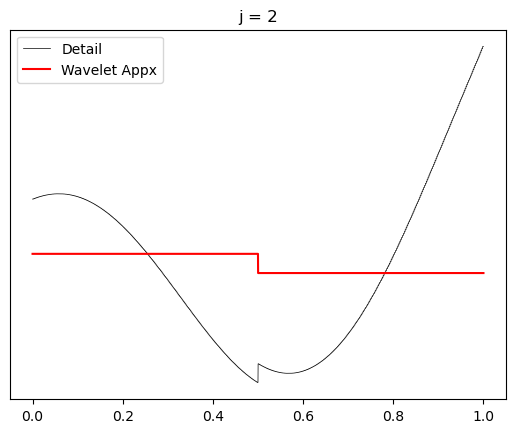

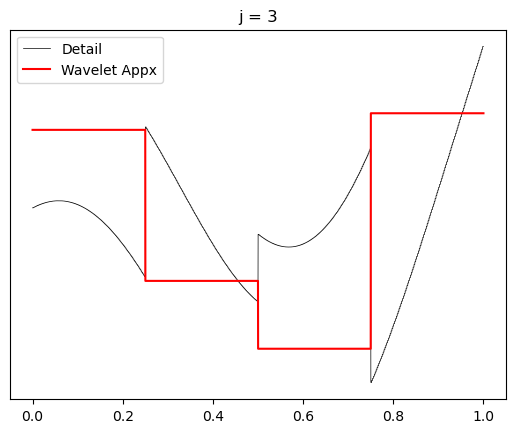

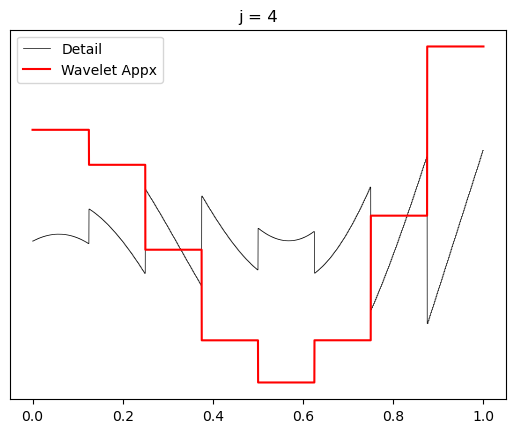

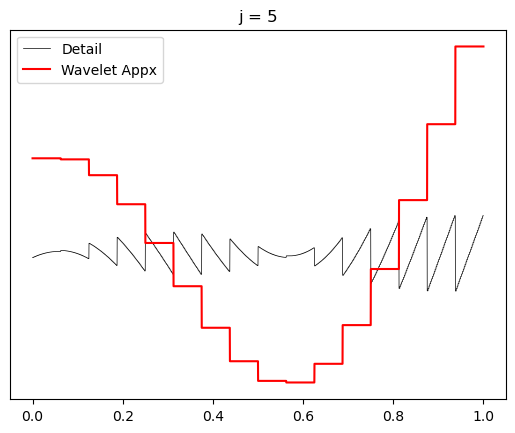

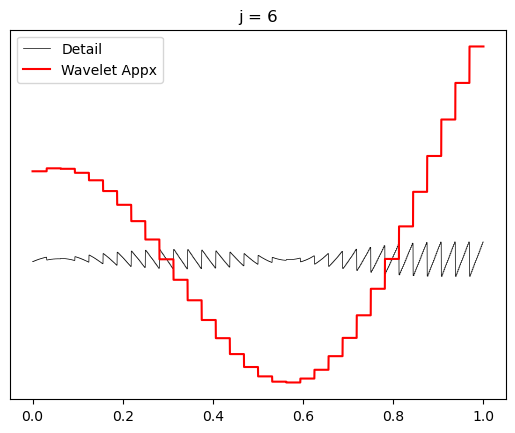

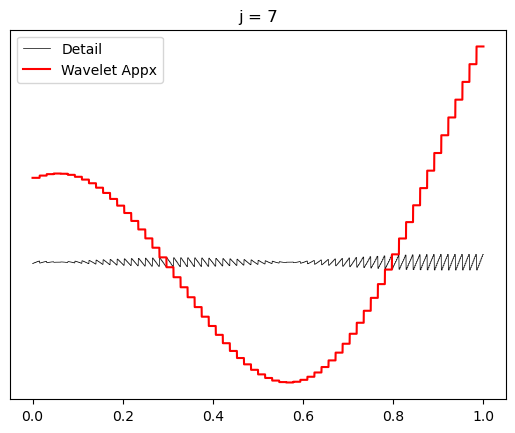

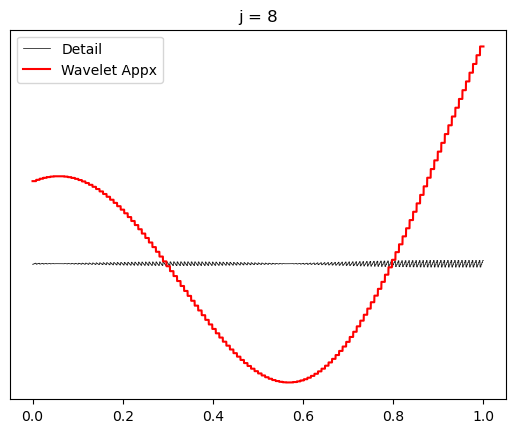

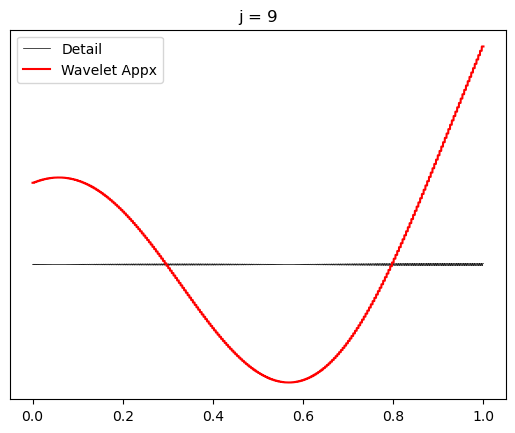

In [416]:
f = lambda t: (np.sin(2*np.pi*t - 5)) / np.sqrt(np.abs(t - (np.pi / 20)))
l = 10
a = -1
b = 1
x = np.linspace(0, 1, 10000, endpoint=False)

for j in range(l):
    T_f, g = sample_f_wavelet_approx_general(f, a, b, l, j)
    plt.figure()
    plt.plot(x, g(x), label="Detail", color="black", linewidth=0.5)
    plt.plot(x, T_f(x), label="Wavelet Appx", color="red")
    plt.yticks([])  
    plt.legend()
    plt.title(f"j = {j}")
    plt.show()

---

IMPORTANT: Please "Restart and Run All" and ensure there are no errors. Then, submit this .ipynb file to Gradescope.